<a href="https://colab.research.google.com/github/abdulsamadkhan/AlignmentTuning/blob/main/RewardTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reward Modeling using `trl` library

## What is Reward model
In the context of **large language models (LLMs)**, a **reward model** is used to **rate different responses** the model can give, based on how helpful, safe, or relevant they are.

**Purpose:** It helps train the LLM to give **better answers** by rewarding good responses and discouraging bad ones—like teaching the model what humans prefer.




## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    </ul>
    <li><a href="#Setup">Setup</a></li>
    <ul>
        <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
        <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
    </ul>
    <li><a href="#Dataset">Data set</a></li>
    <ul>
        <li><a href="#Dataset-features">Data set features</a></li>
    </ul>
    <li><a href="#Model-and-tokenizer-Setup">Model and tokenizer setup</a></li>
    <li><a href="#Training Reward Model">Training Reward Model</a></li>
    <ul>
      <li><a href="#PreProcessing the Data">PreProcessing the Data</a></li>
        <li><a href="#LoRA-configuration">LoRA configuration</a></li>
        <li><a href="#Training-arguments">Training arguments</a></li>
        <li><a href="#Reward-Trainer">Reward trainer</a></li>
    </ul>
    <li><a href="#Evaluating-the-model">Evaluating the model</a></li>
    
</ol>


#1. Objectives
By the end of this tutorial, you will be able to:
- Grasp the fundamentals of how reward modeling guides language model behavior in machine learning.

- Work with real-world datasets by cleaning and preparing them for use in reward-based training tasks.

- Configure a GPT-2 model specifically for sequence classification workflows.

- Process and tokenize text data to make it compatible with transformer-based models.

- Assess model performance by comparing and ranking pairs of generated responses.

- Apply both preprocessing and evaluation methods to various data segments.

- Deepen your understanding of key principles behind transformers and how they relate to reward learning.

- Use special tokens in the tokenizer and adjust model settings to accommodate them effectively.

#2. Setup
## Installing required libraries



In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0  transformers==4.31.0 trl==0.5.0
!pip install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

## Importing required libraries


In [2]:
import json
from datasets import load_dataset, DatasetDict
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments
from peft import LoraConfig, TaskType
from transformers import TrainingArguments
from trl import RewardTrainer



## Defining helper functions


In [ ]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data


#3. Data set

For this turorial we will use the Dahoas/synthetic-instruct-gptj-pairwise data set. In this dataset each data point consist of prompt with a pair of Good and Bad response. The main purpose is to train models to distinguish between better and worse responses.




In [3]:
# Load the Dahoas/synthetic-instruct-gptj-pairwise dataset
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise")
# Display the dataset
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

(…)-00000-of-00001-1e5d57b93c448e7a.parquet:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33143 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 33143
    })
})


### Data set features

To get a better understanding of the data set, let's inspect a few samples. each data point is structured as.

`Prompt:` The input text or question provided to the model to generate a response.

`Chosen:` The response that is considered better or more appropriate for the given prompt.

`Rejected:` The response that is deemed less suitable or lower in quality compared to the chosen one.


In [4]:
for i in range(10):
    print('prompt')
    print(dataset["train"][i]['prompt'],'\n')

    print('chosen')
    print(dataset[ 'train'][i]['chosen'],'\n')

    print('rejected')
    print(dataset[ 'train'][i]['rejected'],'\n')
    print('**********************************************\n')

prompt
I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs. 

chosen
Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients. 

rejected
How do I store a

#4. Model and tokenizer setup
In this section, you set up the tokenizer and the model for training. You can use the GPT-2 model for sequence classification, which helps in determining the quality of responses.

Next, specify the model name or path as "gpt2". To initialize the tokenizer and model, use `GPT2Tokenizer.from_pretrained` and `GPT2ForSequenceClassification.from_pretrained`, respectively, with `num_labels` set to 1 for ranking (a numerical score value). To handle padding, set the `pad_token` of the tokenizer to be the same as the `eos_token` (end-of-sequence token). Similarly, configure the model to use the `eos_token_id` as the `pad_token_id`. This setup ensures that the tokenizer and model are correctly initialized and prepared for sequence classification tasks with GPT-2.


In [5]:
# Define the model name or path
model_name_or_path = "gpt2"

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = GPT2ForSequenceClassification.from_pretrained(model_name_or_path, num_labels=1)

# Add special tokens if necessary
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Define the maximum length
max_length = 1024

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#5. Training Reward Model
## Preprocessing the data
Next, preprocess the data set for training. Then combine the prompt with the chosen and rejected responses into a format suitable for input into the model. This process helps create clear input-output pairs for the model to learn from.

`Lambda Function`: Define a lambda function `get_format` that takes the data set and a response type (chosen or rejected) and combines the prompt with the respective response. Each entry is formatted as a dialogue between "Human" and "Assistant".


In [24]:
def get_format(dataset, res):
    result = []
    for prompt, resp in zip(dataset["train"]["prompt"], dataset["train"][res]):
        formatted = f"\n\nHuman: {prompt}\n\nAssistant: {resp}"
        result.append(formatted)
    return result


`Chosen Samples`: Apply the `get_res` function to create a list of chosen samples.

`Rejected Samples`: Similarly, create a list of rejected samples using the same function.

After applying the function,  you get the following results.


In [7]:
chosen_samples=get_format( dataset,'chosen')
rejected_samples=get_format( dataset,'rejected')
print('chosen',chosen_samples[0])
print('rejected',rejected_samples[0])

chosen 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
rejected 

Huma

To facilitate the training process, create new columns in the data set that combine the prompt with chosen and rejected responses. This combination helps in evaluating the responses in a structured dialogue format.

**Function definition**: Define a function `add_combined_columns` that takes an example (a single data point) and adds two new columns:
- `prompt_chosen`: Combines the `prompt` with the `chosen` response in the same labeled format.
- `prompt_rejected`: Combines the `prompt` with the `rejected` response in the same labeled format.

**Apply function**: The `map` method is used to apply this function to each example in the training split of the data set. This method iterates over all the examples and modifies them in place.


In [8]:
# Define a function to combine 'prompt' with 'chosen' and 'rejected' responses
def add_combined_columns(example):
    # Combine 'prompt' with 'chosen' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_chosen'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["chosen"]

    # Combine 'prompt' with 'rejected' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_rejected'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["rejected"]

    # Return the modified example
    return example

# Apply the function to each example in the 'train' split of the dataset
dataset['train'] = dataset['train'].map(add_combined_columns)

Map:   0%|          | 0/33143 [00:00<?, ? examples/s]

When using pretrained transformers for classification tasks, understanding the maximum sequence length supported by the model is crucial, as pretrained transformers have a fixed maximum token length, for example, GPT-2 has 1024 tokens. Inputs longer than this are truncated, potentially losing important information. So a function is written to determine the max length.


In [9]:
get_max_len= lambda samples: max([len(sample) for sample in samples])
get_max_len

<function __main__.<lambda>(samples)>

In [10]:
print("rejected samples length",get_max_len(rejected_samples))
print("chosen samples length",get_max_len(chosen_samples))

rejected samples length 5011
chosen samples length 3167


Sometimes, you might want to identify samples shorter than a specified maximum length. This can be useful for filtering or handling special cases during preprocessing.

The lambda function `find_short` takes a data set and a maximum length (`max_length`) as input. It uses a list comprehension to iterate over each example in the data set, enumerating both the index and the (chosen, rejected) pair. It zips `prompt_chosen` and `prompt_rejected` to pair each chosen response with its corresponding rejected response. For each pair, it checks if the length of either `chosen` or `rejected` is less than the specified `max_length`. If the condition is met, the index of that pair is included in the resulting list. The resulting list contains the index of all examples where either `prompt_chosen` or `prompt_rejected` is shorter than the specified `max_length`.


In [11]:
find_short = lambda dataset, max_length: [
    i for i, (chosen, rejected) in enumerate(zip(dataset['prompt_chosen'], dataset['prompt_rejected']))
    if len(chosen) < max_length or len(rejected) < max_length
]

To ensure that your dataset only includes samples that meet the required length criteria, filter out any samples that are shorter than the specified `max_length`. This step is important for maintaining consistency in the input data for the model.

Now, use the **GPT-2 model** for classification with a maximum length of 1024 tokens:

1. Set the maximum length (`max_length`) to `1024`.
2. Call the `find_short` function with the training dataset (`dataset['train']`) and `max_length` as arguments.
3. This function will return indices of examples where either `prompt_chosen` or `prompt_rejected` is shorter than `max_length`.
4. Use the resulting indices (`subset_indices`) to create a subset of the training dataset that only includes those examples.
5. Update `dataset['train']` to this filtered subset.
6. Optionally, print or return `subset_indices` for verification.


In [12]:
max_length=1024
subset_indices=find_short (dataset['train'], max_length)
dataset['train'] = dataset['train'].select(subset_indices)
subset_indices[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

The `preprocess_function` tokenizes the `prompt_chosen` and `prompt_rejected` keys, which are crucial for the **RewardTrainer**.

- The `chosen` key represents the **preferred responses**.
- The `rejected` key represents the **less preferred responses**.

Tokenizing these keys allows the model to understand and process the differences between high-quality and low-quality responses.

By providing both `chosen` and `rejected` inputs, the **RewardTrainer** learns to distinguish and prioritize better responses — a key step in training models to **follow instructions effectively**.


In [13]:
# Define a preprocessing function to tokenize the 'prompt_chosen' and 'prompt_rejected' keys
def preprocess_function(examples):
    # Tokenize the 'prompt_chosen' text with truncation and padding to the maximum length
    tokenized_chosen = tokenizer(examples['prompt_chosen'], truncation=True, max_length=max_length, padding="max_length")

    # Tokenize the 'prompt_rejected' text with truncation and padding to the maximum length
    tokenized_rejected = tokenizer(examples['prompt_rejected'], truncation=True, max_length=max_length, padding="max_length")

    # Return the tokenized inputs as a dictionary
    return {
        "input_ids_chosen": tokenized_chosen["input_ids"],  # Token IDs for 'chosen' responses
        "attention_mask_chosen": tokenized_chosen["attention_mask"],  # Attention masks for 'chosen' responses
        "input_ids_rejected": tokenized_rejected["input_ids"],  # Token IDs for 'rejected' responses
        "attention_mask_rejected": tokenized_rejected["attention_mask"],  # Attention masks for 'rejected' responses
    }

The `input_ids_chosen` and `input_ids_rejected` fields contain the **token IDs** for the `chosen` and `rejected` responses, respectively. These are the numerical representations of the text that the model uses.

The `attention_mask_chosen` and `attention_mask_rejected` fields contain the **attention masks** for the `chosen` and `rejected` responses. These masks indicate which tokens should be attended to (`1`) and which should be ignored (`0`).

These fields are essential for the `RewardTrainer` because they provide the **tokenized inputs** and **attention masks** for both preferred and less preferred responses. By comparing the token IDs and attention patterns between the `chosen` and `rejected` responses, the `RewardTrainer` learns to distinguish high-quality from low-quality outputs.

This helps the model improve its ability to **prioritize better responses** during instruction-following tasks.

---

You can apply the `reprocess_function` to one sample:


In [14]:
example=preprocess_function(dataset['train'][0])
example.keys()

dict_keys(['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'])

Now, create a dictionary with 'chosen' and 'rejected' samples from the training data set. This dictionary is created to make it easier to validate the model later.


In [15]:
train_str={'chosen': [sample for sample in dataset['train'] ['prompt_chosen']], 'rejected':[sample for sample in dataset['train'] ['prompt_rejected']]}

The code applies the `preprocess_function` to each example in the training dataset using the `map` method. This function tokenizes the `prompt_chosen` and `prompt_rejected` texts.

- The `batched=True` parameter allows the function to process **multiple examples at once**, which improves efficiency.
- The `remove_columns` parameter specifies a list of columns to be removed after processing:
  - `prompt`
  - `chosen`
  - `rejected`
  - `prompt_chosen`
  - `prompt_rejected`

Removing these columns ensures that only the **tokenized inputs** and **attention masks** generated by `preprocess_function` are retained. This simplifies the dataset structure and makes it more suitable for **model training and validation**.


In [16]:
dataset['train'] = dataset['train'].map(preprocess_function, batched=True, remove_columns=['prompt',"chosen", "rejected",'prompt_chosen', 'prompt_rejected'])

Map:   0%|          | 0/33043 [00:00<?, ? examples/s]

The only columns left are the tokens and masks indexes.


In [17]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 33043
    })
})


Finally, split the data set into training and testing data set. FOr this purpose I can use all the data, but for the interest of tutotrail I will use 15% of the overall data for training and 5% for the test.


In [18]:
from datasets import DatasetDict

# Step 1: Get 20% of the original dataset
small_split = dataset['train'].train_test_split(test_size=0.20, seed=42)

# Step 2: From that 20%, split 75% as train (i.e., 15% of original) and 25% as test (i.e., 5% of original)
small_20_split = small_split['test'].train_test_split(test_size=0.25, seed=42)

# Step 3: Create the new DatasetDict
small_dataset_dict = DatasetDict({
    'train': small_20_split['train'],  # 15% of original
    'test': small_20_split['test']     # 5% of original
})


In [19]:
small_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 4956
    })
    test: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 1653
    })
})

## LoRA Configuration

Now that the training dataset is ready, it's time to begin training using a pretrained transformer model. However, to make training more efficient, it’s recommended to use a **LoRA (Low-Rank Adaptation)** configuration.

### Define LoRA Configuration and Training Arguments

First, initialize a `LoraConfig` for a **sequence classification** task using the `LoraConfig` class from the `peft` library. The configuration includes the following parameters:

- **`task_type=TaskType.SEQ_CLS`**: Specifies the task type — in this case, sequence classification.
- **`inference_mode=False`**: Indicates that the model is in training mode.
- **`r=8`**: Sets the rank of the LoRA matrices.
- **`lora_alpha=32`**: Defines the alpha scaling factor for the LoRA matrices.
- **`lora_dropout=0.1`**: Applies dropout to the LoRA layers to help prevent overfitting.
- **`target_modules=["attn.c_attn", "attn.c_proj"]`**: Specifies the attention layers to be adapted using LoRA — `attn.c_attn` and `attn.c_proj`.

This configuration allows **efficient fine-tuning** by updating only a subset of the model’s parameters, reducing computational cost while maintaining performance.


In [20]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attn.c_attn", "attn.c_proj"]  # Target attention layers
)

## Training Arguments

Define the training arguments using the `TrainingArguments` class from the `transformers` library. These arguments control various aspects of the training process:

- **`per_device_train_batch_size=3`**: Sets the batch size per device (GPU/CPU) to 3.
- **`num_train_epochs=3`**: Specifies that the model will be trained for 3 epochs.
- **`gradient_accumulation_steps=8`**: Accumulates gradients over 8 steps before performing an update, effectively increasing the batch size.
- **`learning_rate=1.41e-5`**: Sets the learning rate for the optimizer to `1.41e-5`.
- **`output_dir="./model_output3"`**: Defines the directory where model checkpoints and outputs will be saved.
- **`logging_steps=10`**: Logs training progress every 10 steps.
- **`eval_steps=500`**: Evaluates the model every 500 steps.
- **`save_steps=500`**: Saves model checkpoints every 500 steps.
- **`save_total_limit=2`**: Keeps only the latest 2 checkpoints, removing older ones to save space.

These settings configure the training loop, covering aspects such as batch size, learning rate, logging frequency, evaluation schedule, and checkpointing strategy.


In [21]:
# Define training arguments

training_args = TrainingArguments(
    per_device_train_batch_size=3,  # Set to 3
    num_train_epochs=3,  # Set to 3
    gradient_accumulation_steps=8,
    learning_rate=1.41e-5,
    output_dir="./model_output3",
    logging_steps=10,
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
)

### RewardTrainer

The `RewardTrainer` is a specialized trainer that is designed to train models with a reward signal. This is often used in reinforcement learning scenarios where the model learns to optimize for better responses. It is initialized with several parameters:

- **model**: The model to be trained
- **args**: The training arguments. Typically, an instance of `TrainingArguments`
- **tokenizer**: The tokenizer used to process the text inputs
- **train_dataset**: The training data set
- **eval_dataset**: The evaluation data set
- **peft_config**: The configuration for LoRA

The `RewardTrainer` orchestrates the training process, handling tasks such as batching, optimization, evaluation, and saving model checkpoints. It is particularly useful for training models that need to learn from feedback signals, improving their ability to generate high-quality responses.


In [22]:
# Initialize RewardTrainer
trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=small_dataset_dict['train'],
    eval_dataset=small_dataset_dict['test'],
    peft_config=peft_config,
)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:123: UserWarning: When using RewardDataCollatorWithPadding, you should set `max_length` in the RewardTrainer's init it will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:134: UserWarning: When using RewardDataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


>Note: You can safely ignore the above warning.


### **Train, Save, and Evaluate the Model**

Now that everything is set up, it's time to train the model using the `RewardTrainer`. This step will help the model learn how to better score responses based on the training data.

---

#### 1. **Train the Model**

To start training, simply use:

```python
trainer.train()
```
This line starts the training process. The model looks at examples in the training dataset and updates its internal parameters to improve how it ranks good vs. bad responses.
#### 2. Save the Trained Model
Once training is finished, you can save the model to a folder for later use:
```
trainer.save_model(output_dir)
```
#### 3. Evaluate the Model
To check how well the model performs, use the evaluate() method:
```
metrics = trainer.evaluate()
print(metrics)
```

In [23]:
output_dir="./model_output3"

# # Train the model
trainer.train()

# # Save the model
trainer.save_model(output_dir)

# # Evaluate the model
metrics = trainer.evaluate()
print(metrics)

model.config.save_pretrained("./backup")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samad19472002 (habib-uni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2411: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.780100
20,1.954700
30,1.948700
40,1.754600
50,1.903200
60,1.910800
70,1.362200
80,1.411100
90,1.611800
100,1.463800


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2411: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'eval_loss': 0.11305869370698929, 'eval_accuracy': 0.9552329098608591, 'eval_runtime': 299.0967, 'eval_samples_per_second': 5.527, 'eval_steps_per_second': 0.692, 'epoch': 2.99}



#6. Evaluating the model

The `RewardTrainer` uses **pairwise comparison** to evaluate how well the model can distinguish between good and bad responses.

- The model is shown two responses at a time:
  - One labeled as **better** (`chosen`)
  - The other labeled as **worse** (`rejected`)

- It assigns a **score (logit)** to each response based on its training.

- These scores reflect how much the model "prefers" each response.

- The response with the **higher score** is selected as the better one.

This process helps the model **learn to choose higher-quality answers**, improving its ability to follow instructions and generate useful outputs.


Next, plot the loss. You can see it converges nicely.



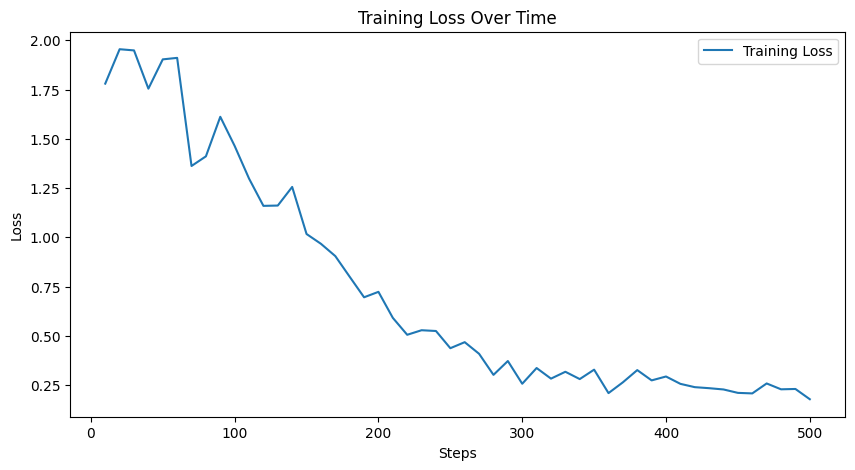

In [25]:
from matplotlib import pyplot as plt
import json
log_file = f"model_output3/checkpoint-500/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract training loss values
steps = []
losses = []
for log in logs["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

The function ```predict_and_get_logits``` code tokenizes input text, performs efficient model inference on GPU (if available), and and outputs (logits).




In [28]:
# Function to make a prediction and get the logits
def predict_and_get_logits(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the logits from the outputs
    logits = outputs.logits.squeeze().item()  # Assuming binary classification and batch size of 1

    return logits

```Let us calculate the logits score for the first choosen prompt```


In [29]:
text1=train_str['chosen'][0]
print(text1)
print("logit score :",predict_and_get_logits(text1))



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
logit score : 0.961788

```Do the same for the rejected sample```


In [30]:
text2=train_str['rejected'][0]
print(text2)
print("logit score :",predict_and_get_logits(text2))



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: How do I store a bagels for eating at a later date?


 You can place the bagels in an airtight container and reheat them in the microwave.  Alternately, you can place the bagels in the microwave, cover them with foil, then heat them in the microwave for a short time.
logit score : -6.834980010986328


In [33]:
# Function to compare two texts
def compare_texts(text1, text2):
    logit1 = predict_and_get_logits(text1)
    logit2 = predict_and_get_logits(text2)

    if logit1 > logit2:
        #print("selected---------")
        #print(text1, f"score: {logit1}")

        return text1
    else:
        #print("selected---------")
        #print(text2,  f"score: {logit2}")

        return text2

### Evaluating Model Performance with Pairwise Comparison

To evaluate the model's performance, a **pairwise comparison** approach is applied on a subset of the dataset.

- **N** is defined as the number of samples to evaluate.
- A counter, `correct_selections`, is initialized to track how often the model correctly selects the preferred response.
- The code iterates over the first **N pairs** of `chosen` and `rejected` responses from the training dataset (`train_str['chosen']` and `train_str['rejected']`).


In [34]:
# Define the number of samples to evaluate
N = 1000

# Initialize a counter for correct selections
correct_selections = 0

# Iterate over the first N pairs of chosen and rejected responses
for chosen, rejected in zip(train_str['chosen'][0:N], train_str['rejected'][0:N]):

    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)

    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / N

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.947


In [35]:
#Conclusion